# Pneumonia X-Ray Image Classification: Modeling

Authors:
- Arthur Kim
    - Github: arthurk2323
- Mia Fryer
    - Github: miazfryer
- Ian Sharff
    - Github: iansharff
___

## Business Understanding

## Data Understanding and Exploration

In [1]:
import os
import sys
import pickle
import PIL
from PIL import Image
import io
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model

import tools.visualizations as vis
import tools.misc as misc

In [2]:
TRAIN_PATH = 'data/split/train'
VAL_PATH = 'data/split/val'
TEST_PATH = 'data/split/test'

BATCH_SIZE = 32
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

In [3]:
counts = misc.count_files([TRAIN_PATH, VAL_PATH, TEST_PATH])


TRAIN
-------------------------
	PNEUMONIA: 2564
	NORMAL: 950

	SUBTOTAL: 3514
VAL
-------------------------
	PNEUMONIA: 855
	NORMAL: 317

	SUBTOTAL: 1172
TEST
-------------------------
	PNEUMONIA: 854
	NORMAL: 316

	SUBTOTAL: 1170
-------------------------
TOTAL: 5856 files


In [4]:
counts

{'train': 3514, 'val': 1172, 'test': 1170}

In [6]:
gen_params = {
    'target_size': (64, 64),
    'color_mode': 'grayscale',
    'class_mode': 'binary',
}

In [8]:
# Get all the data in the directory data/train (2564+950 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_PATH, 
    batch_size=counts['train'],
    **gen_params
)

# Get all the data in the directory data/val (855+317 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_PATH, 
    batch_size=counts['val'],
    **gen_params
)

# Get all the data in the directory data/test (854+316 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_PATH,
    batch_size=counts['test'],
    **gen_params
)

# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [9]:
# Display the shape of the image and label arrays (this cell may take a while to load)
print('TRAIN\n' + '-'*50)
print(f'\ttrain_images shape: {train_images.shape}')
print(f'\ttrain_labels shape: {train_labels.shape}')
print('\nVALIDATION\n' + '-'*50)
print(f'\tval_images shape: {val_images.shape}')
print(f'\tval_labels shape: {val_labels.shape}')
print('\nTEST\n' + '-'*50)
print(f'\ttest_images shape: {test_images.shape}')
print(f'\ttest_labels shape: {test_labels.shape}')
    

TRAIN
--------------------------------------------------
	train_images shape: (3514, 64, 64, 1)
	train_labels shape: (3514,)

VALIDATION
--------------------------------------------------
	val_images shape: (1172, 64, 64, 1)
	val_labels shape: (1172,)

TEST
--------------------------------------------------
	test_images shape: (1170, 64, 64, 1)
	test_labels shape: (1170,)


In [3]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     TRAIN_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     VAL_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     TEST_PATH,
#     seed=123,
#     color_mode='grayscale',
#     label_mode='binary',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE
# )

Found 3514 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.


In [18]:
class_names = {v: k for k, v in train_generator.class_indices.items()}
print(class_names)

{0: 'NORMAL', 1: 'PNEUMONIA'}


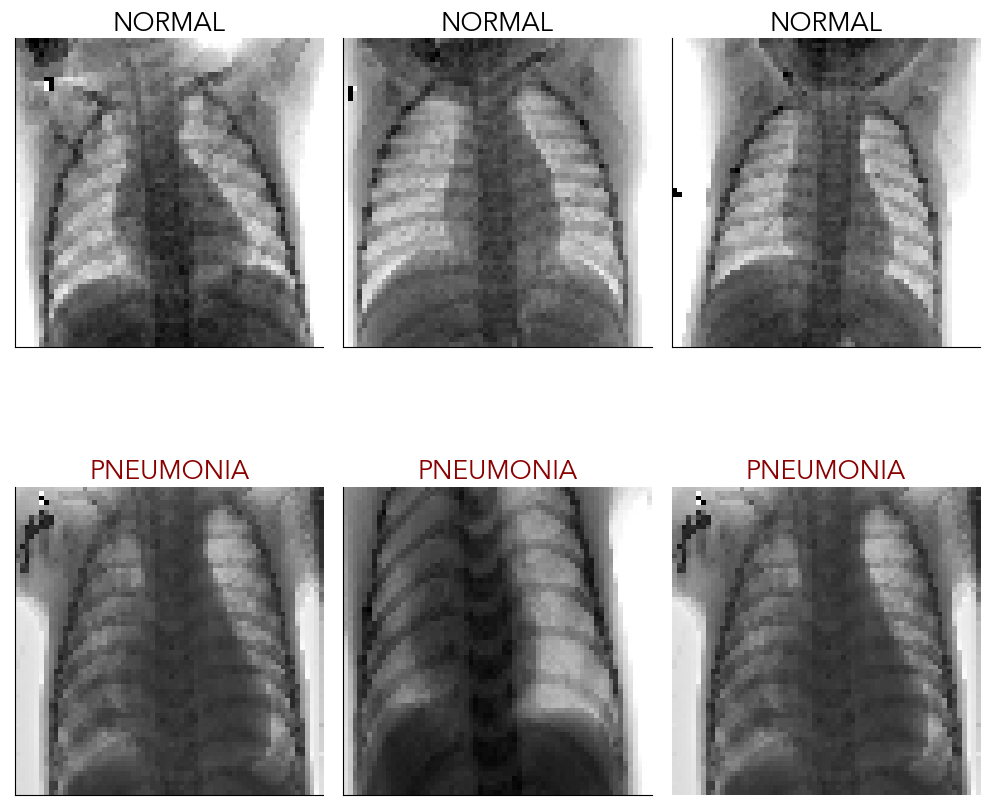

In [47]:
norm_samples = []
pneu_samples = []
i = 0
while len(norm_samples) < 3 and len(pneu_samples) < 3:
    img = train_images[i]
    lab = train_labels[i]
    if len(norm_samples) != 3 and lab == 0:
        norm_samples.append(img)
        i += 1
    elif len(pneu_samples) != 3 and lab == 1:
        pneu_samples.append(img)
        i += 1

# FIX THIS
with plt.style.context('images/presentation.mplstyle'):
    fig, axes = plt.subplots(2, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        if i < 3:
            ax.imshow(norm_samples[i], cmap=plt.cm.binary)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('NORMAL')
        else:
            ax.imshow(pneu_samples[i-4], cmap=plt.cm.binary)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('PNEUMONIA', color='darkred')
    fig.tight_layout()
    plt.axis('off')
    plt.show()

## Model Building and Evaluation

### Dummy Model

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit()

TypeError: fit() missing 1 required positional argument: 'y'

In [12]:
dummy_clf.score(image_batch, label_batch)

0.78125

In [13]:
dummy_clf.score(val_images,val_labels)

NameError: name 'val_images' is not defined

In [13]:
dummy_clf.score(test_images,test_labels)

0.75

### Model 1: Baseline Neural Network

In [ ]:
np.random.seed(123)
model1 = models.Sequential()
model1.add(layers.Dense(2, activation='relu', input_shape=(12288,)))

In [ ]:
model1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(train_img,
                     train_y,
                     epochs=50,
                     batch_size=32,
                     validation_data=(val_img, val_y))

In [ ]:
results_train = model1.evaluate(train_img, train_y)

In [ ]:
results_test = model1.evaluate(test_img, test_y)

In [ ]:
results_train

In [ ]:
results_test

### Model 2: Neural Network with Dense Layers

In [ ]:
np.random.seed(123)
model2 = models.Sequential()
model2.add(layers.Dense(200, activation='relu', input_shape=(12288,)))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(25, activation='relu'))
model2.add(layers.Dense(7, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(train_img,
                     train_y,
                     epochs=50,
                     batch_size=32,
                     validation_data=(val_img, val_y))

In [ ]:
results_train = model2.evaluate(train_img, train_y)

In [ ]:
results_test = model2.evaluate(test_img, test_y)

In [ ]:
results_train

In [ ]:
results_test

### Model 3: Neural Network with Dense and Drop Layers

In [ ]:
np.random.seed(123)
model3 = models.Sequential()
model3.add(layers.Dense(200, activation='relu', input_shape=(12288,)))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(50, activation='relu'))
model3.add(layers.Dense(25, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(7, activation='relu'))
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(train_img,
                     train_y,
                     epochs=50,
                     batch_size=32,
                     validation_data=(val_img, val_y))

In [ ]:
results_train = model3.evaluate(train_img, train_y)

In [ ]:
results_test = model3.evaluate(test_img, test_y)

In [ ]:
results_train

In [ ]:
results_test

### Model 4: Convolutional Neural Network (CNN)

In [24]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [27]:
history4 = model4.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=200,
                    validation_data=(val_images, val_labels))

Epoch 1/10
18/18 [==============================] - 8s 427ms/step - loss: 0.5061 - acc: 0.7297 - val_loss: 0.4942 - val_acc: 0.7304
Epoch 2/10
18/18 [==============================] - 9s 477ms/step - loss: 0.4881 - acc: 0.7331 - val_loss: 0.4755 - val_acc: 0.7346
Epoch 3/10
18/18 [==============================] - 8s 470ms/step - loss: 0.4698 - acc: 0.7436 - val_loss: 0.4592 - val_acc: 0.8020
Epoch 4/10
18/18 [==============================] - 9s 527ms/step - loss: 0.4458 - acc: 0.7769 - val_loss: 0.4286 - val_acc: 0.8131
Epoch 5/10
18/18 [==============================] - 8s 468ms/step - loss: 0.4327 - acc: 0.8051 - val_loss: 0.4168 - val_acc: 0.8729
Epoch 6/10
18/18 [==============================] - 8s 435ms/step - loss: 0.4097 - acc: 0.8219 - val_loss: 0.4642 - val_acc: 0.8242
Epoch 7/10
18/18 [==============================] - 8s 426ms/step - loss: 0.4440 - acc: 0.8102 - val_loss: 0.5143 - val_acc: 0.7713
Epoch 8/10
18/18 [==============================] - 8s 460ms/step - loss: 0.

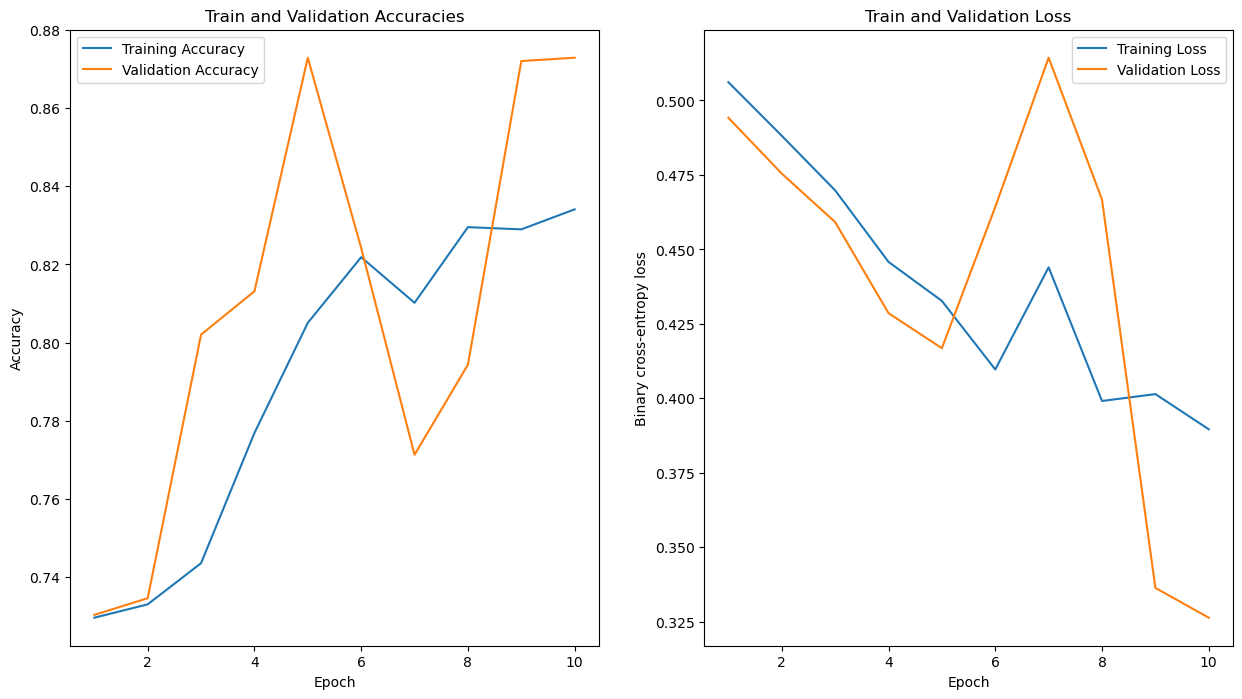

In [30]:
vis.plot_loss_accuracy(history4)
plt.show()

In [ ]:
results_train = model.evaluate(train_images, train_y)

In [ ]:
results_test = model.evaluate(test_images, test_y)

In [ ]:
results_train

In [ ]:
results_test

### Model 5: Base CNN with Focal Loss to solve class imbalancement 

In [ ]:
#pip install focal-loss

In [38]:
from focal_loss import BinaryFocalLoss

In [40]:
model_fl = models.Sequential()
model_fl.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Flatten())
model_fl.add(layers.Dense(64, activation='relu'))
model_fl.add(layers.Dense(1, activation='sigmoid'))

model_fl.compile(loss=BinaryFocalLoss(gamma=2),
              optimizer= 'sgd',
              metrics=['acc'])

In [19]:
history_base_fl = model.fit(train_images, 
                                epochs=10, 
                                validation_data=val_generator
)

Epoch 1/10
20/20 [==============================] - 33s 2s/step - loss: 0.5296 - acc: 0.7297 - val_loss: 0.5197 - val_acc: 0.7295
Epoch 2/10
20/20 [==============================] - 31s 2s/step - loss: 0.5134 - acc: 0.7297 - val_loss: 0.5062 - val_acc: 0.7372
Epoch 3/10
20/20 [==============================] - 31s 2s/step - loss: 0.4953 - acc: 0.7362 - val_loss: 0.4761 - val_acc: 0.7321
Epoch 4/10
20/20 [==============================] - 30s 1s/step - loss: 0.4731 - acc: 0.7587 - val_loss: 0.4656 - val_acc: 0.8575
Epoch 5/10
20/20 [==============================] - 30s 1s/step - loss: 0.4701 - acc: 0.8045 - val_loss: 0.4242 - val_acc: 0.8370
Epoch 6/10
20/20 [==============================] - 32s 2s/step - loss: 0.4779 - acc: 0.7917 - val_loss: 0.4618 - val_acc: 0.8797
Epoch 7/10
20/20 [==============================] - 32s 2s/step - loss: 0.4653 - acc: 0.7994 - val_loss: 0.4085 - val_acc: 0.8874
Epoch 8/10
20/20 [==============================] - 32s 2s/step - loss: 0.4298 - acc: 0.81

In [28]:
test_x_fl, test_y_fl = next(test_generator)

In [29]:
results_test = model_fl.evaluate(test_x_fl, test_y_fl)

6/6 [==============================] - 0s 17ms/step - loss: 0.1738 - acc: 0.4389


In [30]:
model_fl.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [ ]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)))

### Model 6: Transfer Learning - ResNet50V2

In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

In [ ]:
model2 = Sequential()

model2.add(resnet50)    
model2.add(Flatten())
model2.add(Dense(units = 128, activation = "relu"))
model2.add(Dropout(0.5))

model2.add(Dense(units = 1, activation = "sigmoid"))

In [ ]:
resnet50.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model2.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model2.trainable_weights))

In [ ]:
model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
hist2 = model2.fit(train2,validation_data=val2,epochs=5)

In [ ]:
test_results2 = model2.evaluate(test2)

In [ ]:
model2.summary()

### Model 7: CNN with Image Augumentation 

In [52]:
train_datagen_aug = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

In [58]:
train_aug = train_datagen_aug.flow_from_directory(train_path,
                                               batch_size=128,
                                               target_size=(64,64),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

test_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_path, 
        target_size=(64, 64), 
        batch_size = 180,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
val_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_path, 
        target_size=(64, 64),
        batch_size = 32,
        class_mode='binary')

Found 3514 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [59]:
model_aug = models.Sequential()
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(64, activation='relu'))
model_aug.add(layers.Dense(1, activation='sigmoid'))

model_aug.compile(loss=BinaryFocalLoss(gamma=2),
              optimizer= 'sgd',
              metrics=['acc'])

In [60]:
history_aug = model_aug.fit(train_aug, 
                                epochs=10, 
                                validation_data=val_aug)

Epoch 1/10
28/28 [==============================] - 37s 1s/step - loss: 0.1647 - acc: 0.6585 - val_loss: 0.1503 - val_acc: 0.7295
Epoch 2/10
28/28 [==============================] - 36s 1s/step - loss: 0.1507 - acc: 0.7329 - val_loss: 0.1492 - val_acc: 0.7295
Epoch 3/10
28/28 [==============================] - 36s 1s/step - loss: 0.1501 - acc: 0.7299 - val_loss: 0.1489 - val_acc: 0.7295
Epoch 4/10
28/28 [==============================] - 36s 1s/step - loss: 0.1487 - acc: 0.7340 - val_loss: 0.1486 - val_acc: 0.7295
Epoch 5/10
28/28 [==============================] - 36s 1s/step - loss: 0.1523 - acc: 0.7195 - val_loss: 0.1483 - val_acc: 0.7295
Epoch 6/10
28/28 [==============================] - 37s 1s/step - loss: 0.1484 - acc: 0.7345 - val_loss: 0.1478 - val_acc: 0.7295
Epoch 7/10
28/28 [==============================] - 36s 1s/step - loss: 0.1502 - acc: 0.7250 - val_loss: 0.1476 - val_acc: 0.7295
Epoch 8/10
28/28 [==============================] - 36s 1s/step - loss: 0.1497 - acc: 0.72

In [61]:
test_results_aug = model_aug.evaluate(test_aug)

7/7 [==============================] - 8s 1s/step - loss: 0.1472 - acc: 0.7299


In [62]:
model_aug.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

## Analysis, Conclusions, and Future Work